In [341]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [342]:
# Load data for one day
df = pd.read_csv("FROG/FROG_2025-04-03 00_00_00+00_00.csv") 

In [343]:

def parse_df(df):
    """
    :param df: Data frame with data for one day
    :return: Updated data frame with timepstamps indexed
    with minutes, removed timezone and snapshots only
    for the end of every minute
    """
    # Parse timestamp and remove timezone
    df['ts_event'] = pd.to_datetime(df['ts_event']).dt.tz_localize(None)
    
    # Floor timestamp to the minute
    df['minute'] = df['ts_event'].dt.floor('min')
    
    # Keep only the LAST row of each minute -> snapshot of order book at end of minute
    df = df.sort_values('ts_event').groupby('minute').last().reset_index()
    return df


In [344]:
df = parse_df(df)

print(df.head()) # Print first 5 rows
print(f"Num of timestamps: {len(df)}")

               minute                      ts_event  \
0 2025-04-03 13:30:00 2025-04-03 13:30:54.573105705   
1 2025-04-03 13:31:00 2025-04-03 13:31:54.649238867   
2 2025-04-03 13:32:00 2025-04-03 13:32:49.076876499   
3 2025-04-03 13:33:00 2025-04-03 13:33:58.892898161   
4 2025-04-03 13:34:00 2025-04-03 13:34:54.952247773   

                            ts_event.1  rtype  publisher_id  instrument_id  \
0  2025-04-03 13:30:54.573105705+00:00     10             2           6292   
1  2025-04-03 13:31:54.649238867+00:00     10             2           6292   
2  2025-04-03 13:32:49.076876499+00:00     10             2           6292   
3  2025-04-03 13:33:58.892898161+00:00     10             2           6292   
4  2025-04-03 13:34:54.952247773+00:00     10             2           6292   

  action side  depth  price  ...  ask_sz_08  bid_ct_08  ask_ct_08  bid_px_09  \
0      A    A      1  31.54  ...        100          2          1      30.48   
1      C    B      4  31.06  ...        

In [345]:
def df_to_order_books(df):
    """
    :param df: Parsed data frame 
    :return: order_books -> dictionary of all snapshots
    for one day extracted from parsed data frame
    """
    order_books = {}
    
    for idx, row in df.iterrows():
        minute = row['minute']
        
        bids = [[row[f'bid_px_0{i}'], row[f'bid_sz_0{i}']] for i in range(10)]
        asks = [[row[f'ask_px_0{i}'], row[f'ask_sz_0{i}']] for i in range(10)]
        
        order_books[minute] = {
            'bids': bids,
            'asks': asks
        }
    return order_books

In [346]:
order_books = df_to_order_books(df)
print(order_books)

{Timestamp('2025-04-03 13:30:00'): {'bids': [[31.07, 300], [31.01, 100], [31.0, 500], [30.99, 600], [30.88, 100], [30.83, 104], [30.68, 105], [30.67, 200], [30.6, 20], [30.48, 10]], 'asks': [[31.5, 225], [31.54, 5], [31.55, 6], [31.87, 200], [31.99, 100], [32.0, 300], [32.05, 100], [32.13, 200], [32.27, 100], [32.5, 130]]}, Timestamp('2025-04-03 13:31:00'): {'bids': [[31.41, 500], [31.15, 200], [31.1, 100], [31.08, 300], [31.01, 100], [31.0, 250], [30.99, 600], [30.88, 100], [30.86, 100], [30.83, 104]], 'asks': [[31.87, 220], [31.99, 100], [32.0, 300], [32.1, 300], [32.13, 100], [32.19, 300], [32.27, 800], [32.5, 130], [32.51, 100], [32.65, 100]]}, Timestamp('2025-04-03 13:32:00'): {'bids': [[31.41, 500], [31.15, 200], [31.1, 100], [31.08, 300], [31.01, 100], [31.0, 250], [30.99, 600], [30.88, 100], [30.86, 100], [30.83, 104]], 'asks': [[31.87, 220], [31.99, 100], [32.0, 300], [32.1, 300], [32.13, 100], [32.19, 300], [32.27, 800], [32.5, 130], [32.51, 100], [32.65, 100]]}, Timestamp('2

In [347]:

def calculate_slippage_function(order_book_timestemp):
    """
    :param order_book_timestemp: dictionary with bids and asks
    keys, one snapshot of order book 
    :return: x-axis with possible buy amounts and calculated slippage values
    """
    
    max_bid = order_book_timestemp['bids'][0][0]  # best bid
    min_ask = order_book_timestemp['asks'][0][0]  # best ask
    mid_price = (max_bid + min_ask) / 2

    # Prepare ask levels
    asks_np = np.array(order_book_timestemp['asks'])
    ask_prices = asks_np[:, 0]
    ask_sizes = asks_np[:, 1]
    max_amount = int(np.sum(ask_sizes))

    x_values = []
    g_values = []

    for x in range(1, max_amount + 1):
        remaining = x
        cost = 0
        for price, size in zip(ask_prices, ask_sizes):
            if remaining <= 0:
                break
            take = min(size, remaining)
            cost += take * price
            remaining -= take

        avg_price = cost / x
        slippage = avg_price - mid_price

        x_values.append(x)
        g_values.append(slippage)

    return np.array(x_values), np.array(g_values)



In [348]:
#Extract first few samples for testing
i = 0
timestamps_sample = []

for k,v in order_books.items():
    timestamps_sample.append(v)
    i += 1
    if i == 5:
        break


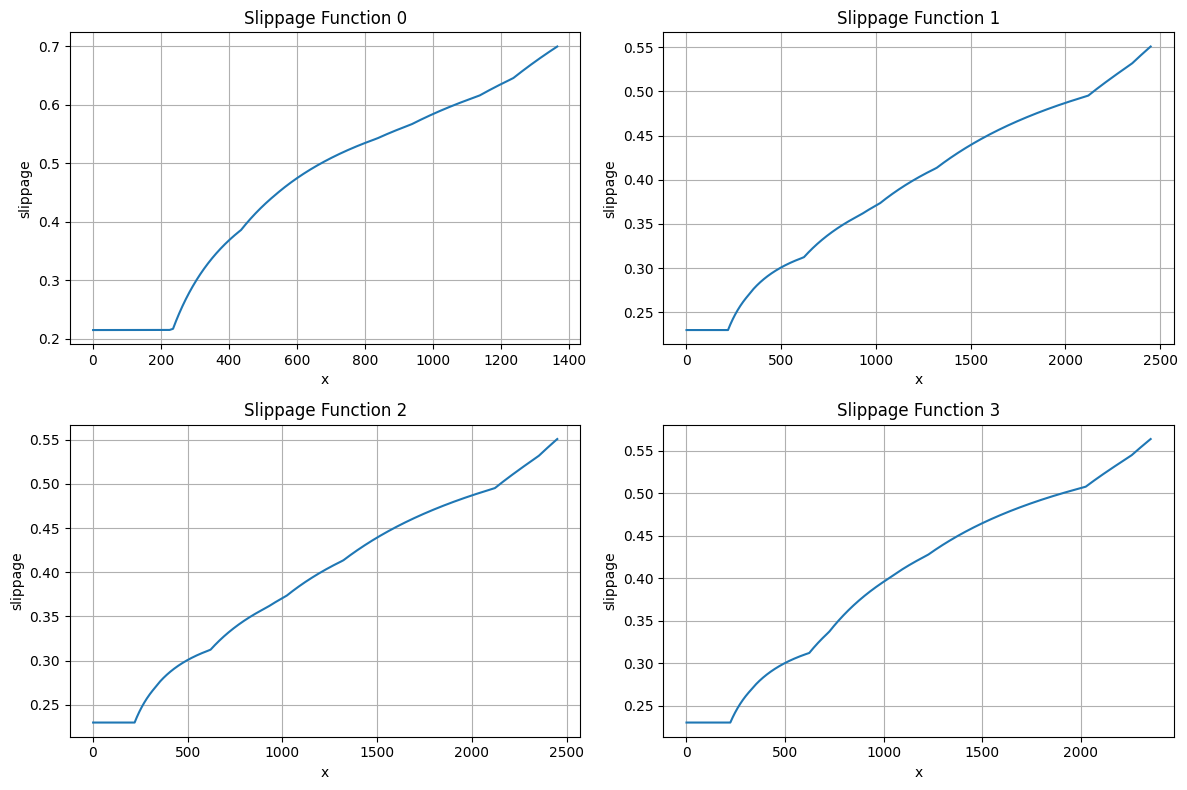

In [349]:
x0,g0 = calculate_slippage_function(timestamps_sample[0])
x1,g1 = calculate_slippage_function(timestamps_sample[1])
x2,g2 = calculate_slippage_function(timestamps_sample[2])
x3,g3 = calculate_slippage_function(timestamps_sample[3])

fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2x2 grid, bigger figure
axes = axes.flatten()

x_list = [x0, x1, x2, x3]
g_list = [g0, g1, g2, g3]

for i in range(4):
    ax = axes[i]
    ax.plot(x_list[i], g_list[i])
    ax.set_title(f"Slippage Function {i}")
    ax.set_xlabel("x")
    ax.set_ylabel("slippage")
    ax.grid(True)

plt.tight_layout()
plt.show()


In [350]:
from scipy.optimize import curve_fit

def fit_piecewise_quadratics_from_values(x, g, breakpoints):
    """
    :param x: array with possible buy amounts 
    :param g: array with calculated slippage values
    :param breakpoints: x-axis values where slippage function 
    changes its analytical expression
    :return: g_fitted -> values of piece-wise quadratic approximation
    of a slippage function, segment_models -> list of tuples containing
    x values, y values, and fitting parameters for each segment
    """
    x = np.array(x)
    g = np.array(g)

    g_fitted = np.zeros_like(g)
    segment_models = []

    num_points = len(x)
    
    # Add final point if missing
    if breakpoints[-1] < num_points:
        breakpoints = breakpoints + [num_points]

    for i in range(1, len(breakpoints)):
        start = breakpoints[i - 1]
        end = breakpoints[i]

        x_seg = x[start:end]
        y_seg = g[start:end]

        if len(x_seg) == 0:
            continue

        # First segment is constant value -> just copy
        if i == 1:
            g_fitted[start:end] = y_seg
            segment_models.append((x_seg, y_seg, ('copy',)))
            continue

        # Too few points for fitting
        if len(x_seg) < 3:
            g_fitted[start:end] = y_seg
            segment_models.append((x_seg, y_seg, ('copy',)))
            continue

        def quad(x, a, b, c):
            return a * x**2 + b * x + c

        try:
            popt, _ = curve_fit(quad, x_seg, y_seg)
            fitted = quad(x_seg, *popt)
        except Exception as e:
            print(f"Fitting failed on segment {i} from {start} to {end}: {e}")
            fitted = y_seg
            popt = ('fail',)

        g_fitted[start:end] = fitted
        segment_models.append((x_seg, fitted, popt))

    return g_fitted, segment_models


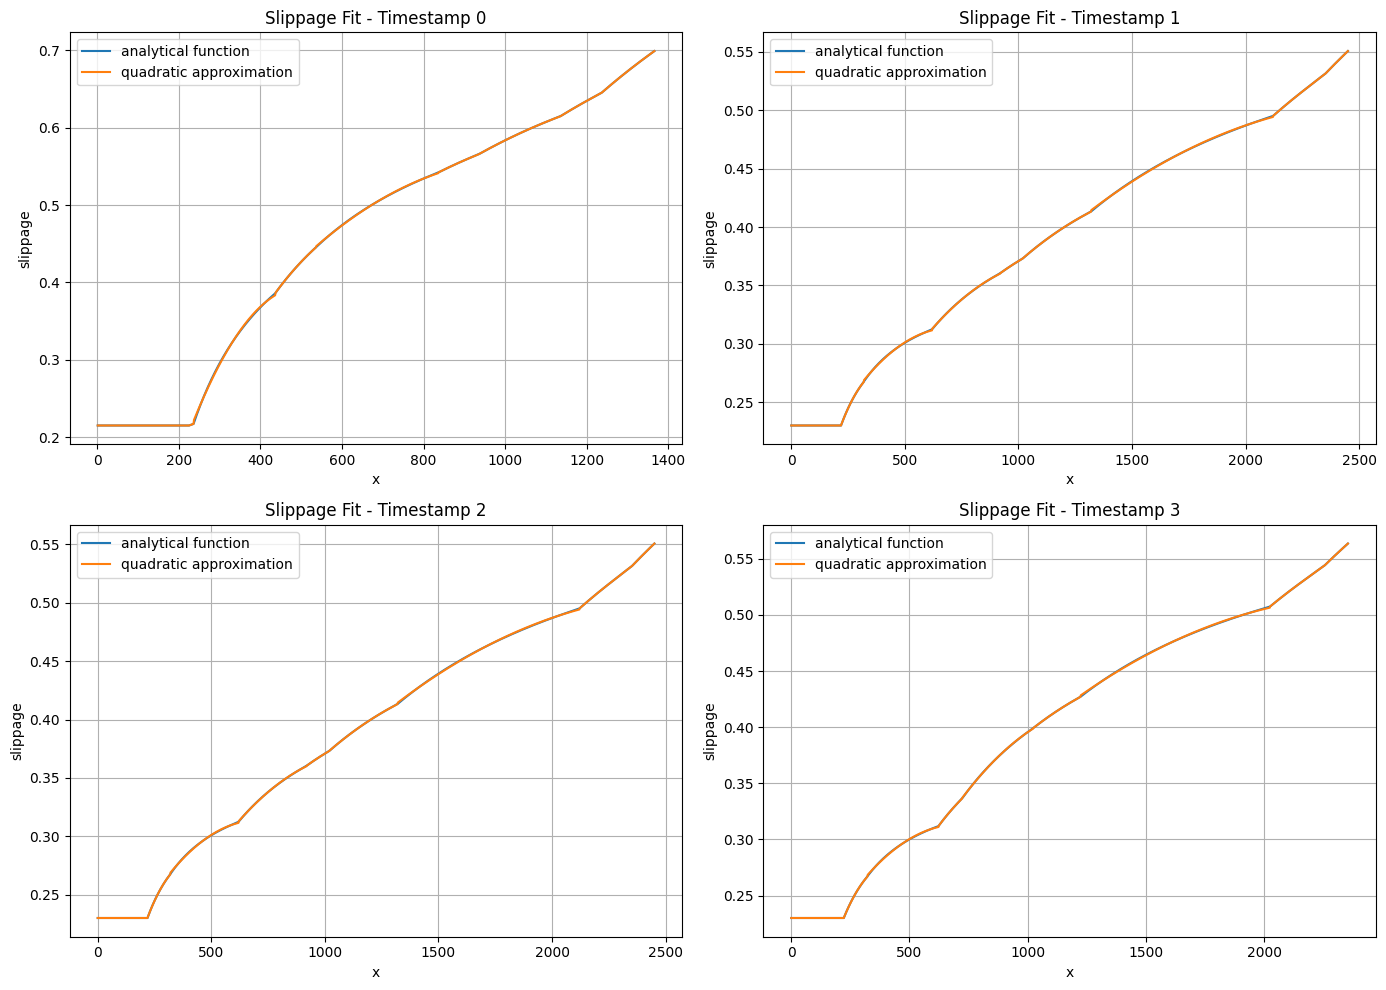

In [351]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10)) 
axes = axes.flatten()

for idx in range(4):
    ax = axes[idx]
    timestamp = timestamps_sample[idx]
    x, g = calculate_slippage_function(timestamp)

    # Compute breakpoints based on ask sizes
    amounts = np.array(timestamp['asks'])[:, 1]
    cumulative = np.cumsum(amounts).astype(int)
    cumulative = cumulative[cumulative < len(x)]
    breakpoints = [0] + cumulative.tolist()

    # Fit piecewise quadratics
    g_fitted, segment_models = fit_piecewise_quadratics_from_values(x, g, breakpoints)

    # Plot original and fitted curves
    ax.plot(x, g, label="analytical function")
    ax.plot(x, g_fitted, label="quadratic approximation")
    ax.set_xlabel("x")
    ax.set_ylabel("slippage")
    ax.set_title(f"Slippage Fit - Timestamp {idx}")
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()


In [352]:

def plot_fair_price(order_books):
    """
    :param order_books: dictionary with order books
    for each minute in one day (from 13:30 to 20:00) 
    :return: /
    """
    best_prices = []
    for k,v in order_books.items():
        best_ask = v['asks'][0][0]
        best_bid = v['bids'][0][0]
        best_prices.append((best_ask + best_bid)/2)
        
    t = list(range(len(best_prices)))
    
    plt.figure()
    plt.plot(t, best_prices)
    plt.grid()
    plt.xlabel("time")
    plt.ylabel("fair price")
    plt.title("Fair price vs time")
    plt.show()
        

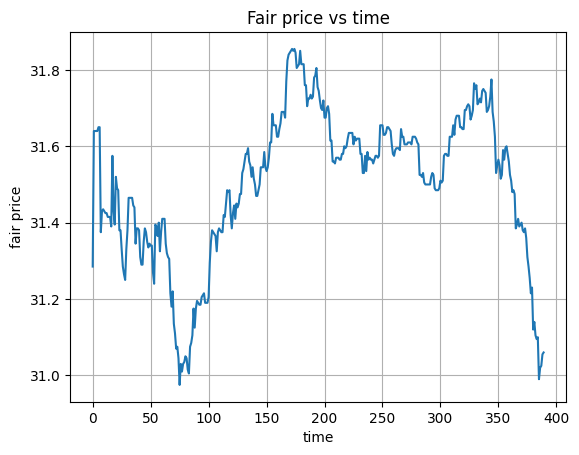

In [353]:
plot_fair_price(order_books)

In [360]:
def naive_allocation(order_books, max_buys):
    """
    :param order_books: dictionary with order books for each minute
    :param max_buys: number of necessary buys in one day 
    :return: allocations -> vector of length 390 -> optimal allocation
    cumulative_slippage -> total slippage cost over the day
    """
    
    allocations = []
    remaining_buys = max_buys
    order_book_items = list(order_books.items())
    total_rounds = len(order_book_items)
    cumulative_slippage = 0

    for t, (timestamp, snapshot) in enumerate(order_book_items):
        rounds_left = total_rounds - t
        if remaining_buys <= 0:
            allocations.append(0)
            continue

        # Naive rule
        ideal_alloc = int(round(remaining_buys / rounds_left))

        # Estimate feasible amount
        x_vals, y_slippages = calculate_slippage_function(snapshot)
        feasible_max = x_vals[-1]
        alloc = min(ideal_alloc, feasible_max, remaining_buys)

        # Interpolate slippage and compute cost
        slippage_per_unit = np.interp(alloc, x_vals, y_slippages)
        total_slippage = slippage_per_unit * alloc

        cumulative_slippage += total_slippage
        allocations.append(alloc)
        remaining_buys -= alloc

    return allocations, cumulative_slippage

        
    

In [361]:
def smart_dynamic_allocation(order_books, max_buys, max_per_step=None, urgency_alpha=2.0, forecast_window=5,
                             beta=1.0, gamma=1.0):
    """
    :param order_books: dictionary with order books for each minute
    :param max_buys: number of necessary buys in one day 
    :param max_per_step: maximum number of stocks to buy at one timestamp
    :param urgency_alpha: for tuning how time influences urgency 
    :param forecast_window: number of past values for calculating expected slippage
    :param beta: for tuning urgency impact to allocation
    :param gamma: for tuning favorability impact to allocation
    :return: allocations -> vector of length 390 -> optimal allocation
             cumulative_slippage -> total slippage cost over the day
    """
    
    allocations = []
    slippage_history = []
    cumulative_slippage = 0
    remaining_buys = max_buys
    order_book_items = list(order_books.items())
    total_rounds = len(order_book_items)

    for t, (timestamp, snapshot) in enumerate(order_book_items):
        remaining_rounds = total_rounds - t
        if remaining_buys <= 0:
            allocations.append(0)
            continue

        ideal_per_round = remaining_buys / remaining_rounds

        x_vals, y_slippages = calculate_slippage_function(snapshot)

        if ideal_per_round > x_vals[-1]:
            ideal_per_round = x_vals[-1]

        current_slippage = np.interp(ideal_per_round, x_vals, y_slippages)
        current_total_slippage = current_slippage * ideal_per_round

        if slippage_history:
            expected_slippage = np.mean(slippage_history[-forecast_window:])
        else:
            expected_slippage = current_slippage

        favorability = expected_slippage / (current_slippage + 1e-6)
        urgency = np.exp(urgency_alpha * t / total_rounds)

        raw_alloc = ideal_per_round * (urgency ** beta) * (favorability ** gamma)
        feasible_max = x_vals[-1]
        alloc = int(min(raw_alloc, feasible_max, remaining_buys))
        if max_per_step:
            alloc = min(alloc, max_per_step)

        # Add to cumulative slippage
        step_slippage = np.interp(alloc, x_vals, y_slippages) * alloc
        cumulative_slippage += step_slippage

        allocations.append(alloc)
        remaining_buys -= alloc
        slippage_history.append(current_slippage)

    if remaining_buys > 0:
        allocations[-1] += remaining_buys
        # Recalculate slippage for the final correction
        x_vals, y_slippages = calculate_slippage_function(order_book_items[-1][1])
        extra_slippage = np.interp(remaining_buys, x_vals, y_slippages) * remaining_buys
        cumulative_slippage += extra_slippage

    return allocations, cumulative_slippage


In [364]:
# Testing naive vs smart allocation

S = 1000
allocations_1, cumulative_slippage_1 = naive_allocation(order_books, S)
print(f"Allocation vector: {allocations_1}")
print(f"Sum of allocations: {sum(allocations_1)}")
print(f"Cumulative slippage: {cumulative_slippage_1}")

Allocation vector: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2,

In [365]:
allocations_2, cumulative_slippage_2 = smart_dynamic_allocation(order_books, S)
print(f"Allocation vector: {allocations_2}")
print(f"Sum of allocations: {sum(allocations_2)}")
print(f"Cumulative slippage: {cumulative_slippage_2}")

Allocation vector: [2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 3, 3, 3, 2, 2, 13, 6, 4, 6, 3, 3, 3, 3, 3, 1, 2, 3, 4, 5, 2, 1, 2, 2, 2, 4, 4, 4, 6, 6, 5, 1, 2, 2, 2, 2, 3, 4, 5, 5, 5, 4, 3, 1, 2, 3, 4, 4, 5, 3, 2, 2, 3, 2, 9, 3, 4, 2, 1, 4, 7, 5, 4, 4, 3, 2, 4, 6, 4, 4, 5, 2, 3, 3, 3, 3, 2, 4, 1, 5, 3, 3, 4, 4, 3, 4, 5, 4, 3, 3, 4, 3, 3, 2, 5, 2, 3, 3, 3, 3, 4, 3, 3, 4, 4, 8, 5, 4, 3, 3, 3, 2, 4, 4, 3, 5, 4, 3, 3, 5, 3, 4, 8, 7, 3, 4, 4, 5, 3, 8, 5, 3, 3, 7, 3, 2, 2, 3, 4, 11, 4, 4, 4, 4, 12, 7, 3, 3, 3, 5, 5, 2, 2, 3, 3, 4, 3, 4, 3, 7, 5, 4, 4, 5, 3, 4, 6, 4, 3, 1, 4, 4, 4, 3, 3, 5, 5, 5, 8, 4, 4, 2, 2, 3, 4, 3, 3, 3, 4, 3, 3, 3, 4, 4, 4, 4, 4, 2, 2, 2, 4, 4, 4, 5, 4, 3, 3, 3, 4, 3, 3, 4, 3, 3, 3, 6, 5, 2, 3, 3, 3, 1, 2, 3, 3, 6, 3, 3, 1, 2, 2, 2, 3, 2, 3, 3, 2, 3, 4, 3, 3, 2, 2, 2, 2, 3, 3, 2, 5, 3, 3, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 5, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 2, 1, 0, 0, 0,